# Analyzing NYC High School Data

This is a guided project aiming to practice data cleaning. This project analyzes the the US educational system by investigating the correlations between SAT scores and other factors, e.g. races and genders.

# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

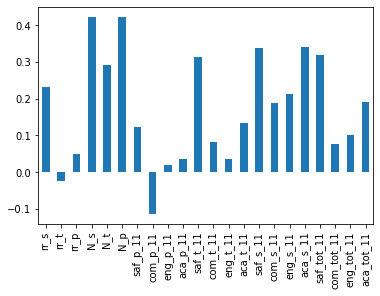

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

combined.corr()["sat_score"][survey_fields].plot.bar()
plt.show()

The fields that have high correlation with `sat_score` are:

| No.| Fields | Description |
|----|--------|-------------|
| 1.| N_s | Number of student respondents |
| 2.| N_t | Number of teacher respondents |
| 3.| N_p | Number of parent respondents |
| 4.| saf_t_11 | Safety and Respect score based on teacher responses |
| 5.| saf_s_11 | Safety and Respect score based on student responses |
| 6.| aca_s_11 | Academic expectations score based on student responses |
| 7.| saf_tot_11 | Safety and Respect total score |

The high correlations between `N_s`, `N_t`, and `N_p` and `sat_score` are reasonable as they are number of respondents.

The correlations for `saf_t_11` and `saf_s_11` with `sat_score` are also reasonable as safer environment could be more benefical and suitable for studying, and hence, higher SAT score. Consequently, `saf_tot_11` correlates with `sat_score` as it is a Safety and Respect total score.

Student's academic expectations score (`aca_s_11`) highly correlates with `sat_score` while teacher's and parent's academic expectations scores, `aca_t_11` and `aca_p_11`, are much lower. This could signal how each group perceives academic standard differently.


# Exploring Safety and SAT Scores

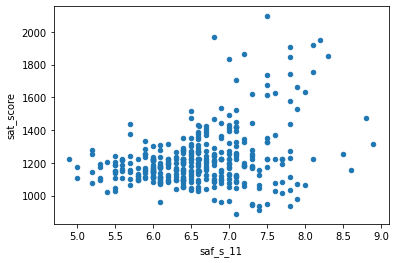

In [12]:
combined.plot.scatter("saf_s_11", "sat_score")
plt.show()

There seems to be a correlation between safety and SAT score. The students in lower-safety-score schools seem to have lower average SAT scores. The schools with safety score of less than 6.5 have an average SAT score of 1500-ish or less. The schools with higher safety score could have an average SAT score of 1800 or even 2000.

## Exploring Safety and SAT Scores by borough

In [13]:
bor_sas = combined.groupby("boro").agg(numpy.mean)["saf_s_11"]
print(bor_sas)

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


Manhantan has the highest safety score, followed by Queens, while Brooklyn has the lowest safety score.

# Exploring Race and SAT Scores

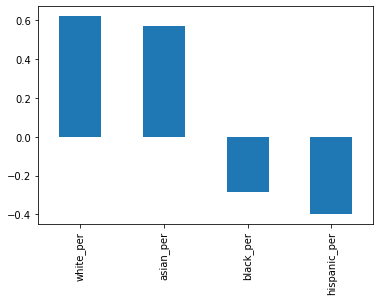

In [14]:
races = ["white_per", "asian_per", "black_per", "hispanic_per"]

combined.corr()["sat_score"][races].plot.bar()
plt.show()

There seems to be higher correlation between `white_per`, `asian_per`, and `sat_score`, whereas a negative correlation between `black_per`, `hispanic_per`, and `sat_score` could be observed. This means that the schools with higher percentage of white or asian students tend to have higher SAT scores, on average, than schools with higher percentage of black or hispanic students.

## Exploring Hispanic students and SAT Scores

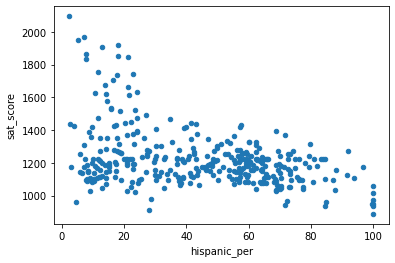

In [15]:
combined.plot.scatter("hispanic_per", "sat_score")
plt.show()

The scatter plot above shows that the higher percentage of hispanic students in schools, the lower average SAT scores the schools have. The schools with 100% hispanic students have the average SAT score of 1000-1100 or even lower, whereas the schools with less than 30% hispanic students could have the average SAT scores as high as 1800 or more.

In [16]:
combined[combined["hispanic_per"] > 95]["SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Above is a list of schools with more than 95% hispanic students. The schools are founded to serve Spanish-speaking students who have just immigrated to the US. This could explain the low SAT scores of these schools.

In [17]:
combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Above is a list of schools with less than 10% hispanic students, with an average SAT score of higher than 1800. These schools are public "magnet" schools and offer specialized courses to attract talented students. As a result, these schools have higher SAT scores on average.

# Exploring Gender and SAT Scores

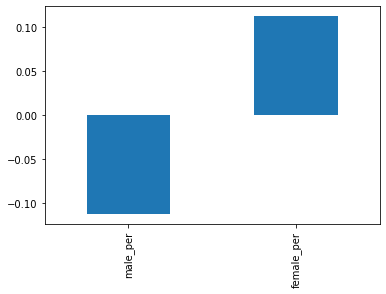

In [18]:
gender = ["male_per", "female_per"]

combined.corr()["sat_score"][gender].plot.bar()
plt.show()

The correlations between each gender and `sat_score` are quite low, at about 0.10 only. However, it could be observed that the schools with higher percentage of male students have a negative correlation with `sat_score`, whereas the schools with higher percentage of female students have a positive correlation.

## Exploring female students and SAT Scores

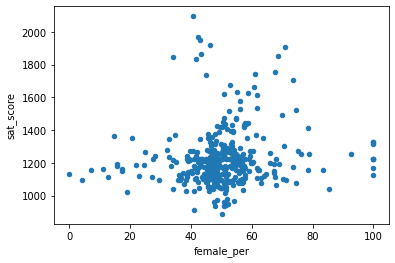

In [19]:
combined.plot.scatter("female_per", "sat_score")
plt.show()

There is no strong correlation between `female_per` and `sat_score`. The all-female schools have lower average SAT scores than the schools with 40-80% female students. The schools with around 40% female students have the highest average SAT scores.

In [20]:
combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"]

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools are selective schools with an admission rate of approximately 1-2.5%. They offer special curricula and extra activities.

# Exploring AP Scores and SAT Scores

In [21]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

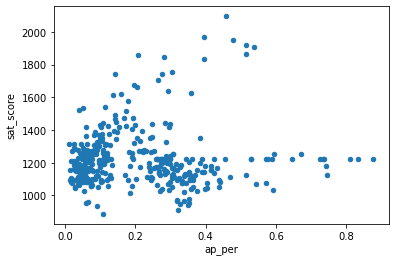

In [22]:
combined.plot.scatter("ap_per", "sat_score")
plt.show()

There is no strong correlation between `sat_score` and `ap_per`. The schools with higher percentage of AP exam takers seems to have higher average SAT scores, but this isn't always true as all schools with more than 60% of AP exam takers have lower average SAT scores than schools with less than 60% of AP exam takers.